## Assignment 3 - Predicting Airbnb Prices

### <i> Group Members: Sayantan Raut, Dhruv Jain, Shubhankar Rekhade </i> 


The file AirbnbTrain.csv contains data on 1700 Airbnb listings in Hollywood, CA. The dataset
contains features such as the location (by latitude and longitude), number of guests accomodated,
number of beds, and other variables. The dataset also contains the price per night of each Airbnb
listing. Your assignment will be to formulate an optimization model to predict the price of Airbnb
listings using this dataset.
Note: Given a set of model coefficients β1, β2, . . . , βd, the average prediction error of the model β
for a data set (xi, yi), i = 1, . . . , n is given by:
<center>

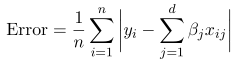
</center>



#### Question 1:
Model 1. Formulate the least absolute deviations regression problem as a linear program. Solve the linear program using the data given in the file AirbnbTrain.csv. What is the prediction error, in $/night, of your model on the test set (provided in AirbnbTest.csv)?

In [19]:
import pandas as pd
from gurobipy import *
import numpy as np

train_data = pd.read_csv('AirbnbTrain.csv')

test_data = pd.read_csv('AirbnbTest.csv')

X_train_not_coded = train_data.drop(columns=['price'])
y_train_not_coded = train_data['price']

X_test_not_coded = test_data.drop(columns=['price'])
y_test_not_coded = test_data['price']

X_train_not_coded.head()

,latitude,longitude,Entire home,accommodates,bathrooms,bedrooms,beds,cleaning_fee,minimum_nights,number_of_reviews,review_scores_rating,instant_bookable
0,34.103701,-118.332241,1,13,2.0,3,2,150,2,1,100,1
1,34.099484,-118.331645,1,8,2.0,2,4,150,1,11,96,1
2,34.104321,-118.329662,1,4,1.0,0,1,55,1,1,80,0
3,34.101028,-118.317848,0,2,1.0,1,1,20,1,8,98,0
4,34.098292,-118.324980,1,2,1.0,1,1,20,1,11,96,0


In [20]:
model1 = Model()

total_features = X_train_not_coded.shape[1]
total_obs = len(X_train_not_coded)

b = model1.addVars(total_features, vtype = GRB.CONTINUOUS)
z = model1.addVars(total_obs, vtype = GRB.CONTINUOUS)

# Objective function:
model1.setObjective((1/total_obs)*(sum(z[i] for i in range(total_obs))), GRB.MINIMIZE)

# Cosntraints:
for i in range(total_obs):
    model1.addConstr(z[i] >= y_train_not_coded.iloc[i] - sum(X_train_not_coded.iloc[i, j] * b[j] for j in range(total_features)))
    model1.addConstr(z[i] >= sum(X_train_not_coded.iloc[i, j] * b[j] for j in range(total_features)) - y_train_not_coded.iloc[i])

model1.update()
model1.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.0.0 23A344)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3400 rows, 1712 columns and 41372 nonzeros
Model fingerprint: 0x473882ba
Coefficient statistics:
  Matrix range     [5e-01, 5e+02]
  Objective range  [6e-04, 6e-04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+03]
Presolve time: 0.01s
Presolved: 3400 rows, 1712 columns, 41372 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 12
 AA' NZ     : 2.995e+04
 Factor NZ  : 3.260e+04 (roughly 2 MB of memory)
 Factor Ops : 4.141e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.13176381e+03  0.00000000e+00  1.36e+03 0.00e+

In [21]:
coeffs = [b[j].x for j in range(total_features)]
print(coeffs)

y_pred = X_test_not_coded.dot(coeffs)

pred_error = np.round(abs(y_pred - y_test_not_coded).mean(), 2)
print("Average Prediction Error: ", pred_error)

[290.251466351811, 84.03092762129587, 36.78323755553764, 9.936817142125031, 31.69433118878847, 19.703957114477934, 0.0, 0.3106162814102505, 0.0, 0.0, 0.2681158824601207, 5.1674543733493]
Average Prediction Error:  35.6


The average prediction error that we see above is <b>$35.6 / night</b>

#### Question 2:
Model 2. Suppose that to improve interpretability, you wish to build a model that predicts Airbnb prices using only the three most important variables. Modify Model 1 by including a constraint that allows at most three variables to have non-zero coefficients.
1. List the names and coefficients of the three variables selected by the optimization model.
2. What is the new prediction error, in $/night, of Model 2?

In [22]:
model2 = Model()

b_2 = model2.addVars(total_features, vtype = GRB.CONTINUOUS)
z = model2.addVars(total_obs, vtype = GRB.CONTINUOUS)
f = model2.addVars(total_features, vtype = GRB.BINARY)

# Objective function:
model2.setObjective((1/total_obs)*sum(z[i] for i in range(total_obs)), GRB.MINIMIZE)

# Cosntraints:
for i in range(total_obs):
    model2.addConstr(z[i] >= y_train_not_coded.iloc[i] - sum(X_train_not_coded.iloc[i, j] * b_2[j] * f[j] for j in range(total_features)))
    model2.addConstr(z[i] >= sum(X_train_not_coded.iloc[i, j] * b_2[j] * f[j] for j in range(total_features)) - y_train_not_coded.iloc[i])

model2.addConstr(sum(f[j] for j in range (total_features)) <= 3)

model2.update()
model2.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.0.0 23A344)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 1724 columns and 12 nonzeros
Model fingerprint: 0x8a56caa9
Model has 3400 quadratic constraints
Variable types: 1712 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [5e-01, 5e+02]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [6e-04, 6e-04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 3e+00]
  QRHS range       [1e+01, 2e+03]
Found heuristic solution: objective 2.000000e+09
Presolve added 824 rows and 410 columns
Presolve time: 0.06s
Presolved: 3421 rows, 2170 columns, 32958 nonzeros
Presolved model has 24 SOS constraint(s)
Found heuristic solution: objective 144.9682353
Variable types: 2146 continuous, 24 integer (24 binary)

Root relaxation: objective 3.642625e+01, 2205 iterations, 0.1

In [23]:
coeffs = [b_2[j].x for j in range(total_features)]
# print(coeffs)

nonzero_coeffs = [(j, b_2[j].x) for j in range(total_features) if b_2[j].x > 0]

# printing as table
print("3 variables in the model:")
for k,v in nonzero_coeffs:
    print(X_train_not_coded.columns[k], " ", v)

y_pred = X_test_not_coded.dot(coeffs)

pred_error = np.round(abs(y_pred - y_test_not_coded).mean(), 2)
print("\nAverage Prediction Error: ", pred_error)

3 variables in the model:
Entire home   52.0
accommodates   14.0
bedrooms   32.0

Average Prediction Error:  37.74


The names and coefficients of the three variables are: <br>
 <b>Entire Home : 52 <br>
    Accomodates : 14 <br>
    Bedrooms : 32 </b>

The <i>new</i> average prediction error that we see for model 2 is <b>$37.74 / night</b>

#### Question 3:
Model 3. Suppose now you wish to build a model that predicts Airbnb listing price using only three variables, where one of the variables is the number of beds.
1. List the names and coefficients of the two other variables selected by the optimization model.
2. Which variable was in Model 2 but is no longer in Model 3? Briefly explain in 1-2 sentences why this variable might have been dropped.
3. What is the new prediction error, in $/night, of Model 3?

In [24]:
model3 = Model()

b_3 = model3.addVars(total_features, vtype = GRB.CONTINUOUS)
z = model3.addVars(total_obs, vtype = GRB.CONTINUOUS)
f = model3.addVars(total_features, vtype = GRB.BINARY)

# Objective function:
model3.setObjective((1/total_obs)*sum(z[i] for i in range(total_obs)), GRB.MINIMIZE)

# Cosntraints:
for i in range(total_obs):
    model3.addConstr(z[i] >= y_train_not_coded.iloc[i] - sum(X_train_not_coded.iloc[i, j] * b_3[j] * f[j] for j in range(total_features)))
    model3.addConstr(z[i] >= sum(X_train_not_coded.iloc[i, j] * b_3[j] * f[j] for j in range(total_features)) - y_train_not_coded.iloc[i])

model3.addConstr(sum(f[j] for j in range (total_features)) <= 3)
model3.addConstr(f[6] >= 1)

model3.update()
model3.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.0.0 23A344)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 1724 columns and 13 nonzeros
Model fingerprint: 0x2868f860
Model has 3400 quadratic constraints
Variable types: 1712 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [5e-01, 5e+02]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [6e-04, 6e-04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
  QRHS range       [1e+01, 2e+03]
Presolve added 823 rows and 409 columns
Presolve time: 0.05s
Presolved: 3419 rows, 2166 columns, 32952 nonzeros
Presolved model has 22 SOS constraint(s)
Variable types: 2144 continuous, 22 integer (22 binary)
Found heuristic solution: objective 60.5111765

Root relaxation: objective 3.642625e+01, 2480 iterations, 0.16 seconds (0.42 work units)

    Nodes    |    Cur

In [29]:
coeffs = [b_3[j].x for j in range(total_features)]
print(coeffs)

nonzero_coeffs = [(j, np.round(b_3[j].x,2)) for j in range(total_features) if b_3[j].x > 0]

# printing as table
print("3 variables in the model:")
for k,v in nonzero_coeffs:
    print(X_train_not_coded.columns[k], " ", v)

y_pred = X_test_not_coded.dot(coeffs)

pred_error = np.round(abs(y_pred - y_test_not_coded).mean(), 2)
print("\nAverage Prediction Error: ", pred_error)

[0.0, 0.0, 67.875, 0.0, 0.0, 47.37499999999999, 12.125000000000002, 0.0, 0.0, 0.0, 0.0, 0.0]
3 variables in the model:
Entire home   67.88
bedrooms   47.37
beds   12.13

Average Prediction Error:  38.6


The coefficient of the variable <i>beds</i> is <b>12.13</b>

The names and coefficients of the two other variables are: <br>
 <b>Entire Home : 67.88 <br>
    Bedrooms : 47.37 </b>   

The variable present in model 2 but absent from model 3 is <i>accomodates</i>. In model 2, the model was deciding the three variables based on the least absolute deviations. In model 3, the model dropped the one with the highest absolute deviation among the 3, and replaced it with the variable <i>beds </i>, which we fixed. This is why model 3 dropped <i>accomodates</i>.

The <i>new</i> average prediction error that we see for model 3 is <b>$38.6 / night</b>